# Information retrieval

In [72]:
import nltk
import string, pprint, os
import codecs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt 
import numpy as np
from collections import defaultdict
import unidecode
import glob, re, pprint, csv
import xml.etree.ElementTree as ET

In [2]:
DOC_DIR="data/texts"

## Clexical analysis

### Word frequency

In [3]:
def get_tokens(texts):
    tokens = [word  for text in texts for word in nltk.word_tokenize(text)]
    return tokens

In [4]:
def get_most_common_tokens(tokens, num):
    count = Counter(tokens)
    return count.most_common(num)

In [5]:
def clean_text(text):
        lowers = text.lower() 
        no_punctuation = lowers.translate(None, string.punctuation)
        return no_punctuation

In [6]:
def get_text(file):
    with open(file, 'r') as d:
        text = d.read()
        return clean_text(text)

In [7]:
def get_texts(dir):
    text_list , text_names = [] , []
    for subdir, dirs, files in os.walk(dir):
        for file in files:
            if file.endswith(".txt"):
                file_path = subdir + os.path.sep + file
                text_list.append(get_text(file_path))
                text_names.append(file)

    return text_list

In [8]:
texts = get_texts(DOC_DIR)
tokens = get_tokens(texts)
most_common = get_most_common_tokens(tokens, 10)
print (most_common)

[('sent', 7112), ('the', 4400), ('of', 2736), ('and', 2725), ('to', 2382), ('in', 1793), ('a', 1525), ('is', 981), ('that', 906), ('for', 899)]


Clearly they are not good describtors because such words exist in all texts and won't help us differentiate different texts. We can choose better descripters by droping these stopwords and calculating again words frequency and/or use TF-IDF.

### Words lemmatizing 

In [38]:
def get_tokens_lem(texts):
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens = []
    for text in texts:
        for word in nltk.word_tokenize(text):
            word = word.replace("é", "e")
            word = word.replace("è", "e")
            tokens.append(wordnet_lemmatizer.lemmatize(word))
                
    return tokens

In [39]:
texts = get_texts(DOC_DIR)
tokens = get_tokens_lem(texts)
most_common = get_most_common_tokens(tokens, 10)
print (most_common)

[('sent', 7112), ('the', 4400), ('of', 2736), ('and', 2725), ('to', 2382), ('a', 2099), ('in', 1793), ('is', 981), ('that', 906), ('for', 899)]


=> Words that have the same root are represented by the same word. 

### Pos tagging 

In [54]:
tagged = nltk.pos_tag(tokens)

In [63]:
tags = [w[1] for w in tagged]

In [68]:
count = Counter(tags)
print count.most_common(1)

[('NN', 28178)]


The most frequent category is nouns : I think it's an interesting category because nouns can bring so much value and meaning to understand a context of a text.

### Visualizations 

In [70]:
freq = [token[1] for token in get_most_common_tokens(tokens, len(tokens))]

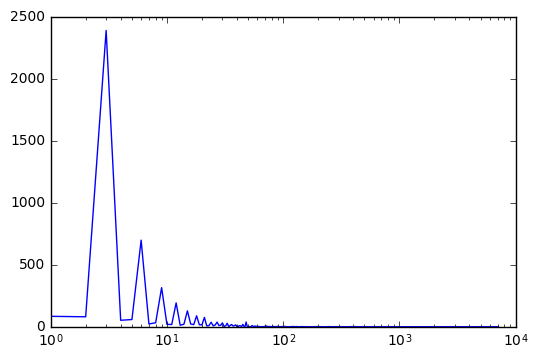

In [78]:
x,y = np.unique(freq, return_counts=True)
plt.semilogx(x,y)
plt.show()

## Sequence Similarity Search

### Terms frequency versus TFIDF
TFIDF includes a description of both terms frequency and its presence in various documents : if a term is frequent in all documents that wouldn't help us do specific tasks. That's why TFIDF is more accurate and interstng when representing words by numeric values.

### Similarity check 

In [48]:
def get_similarity(text1, text2, v):
    t1 = v.transform([text1])
    t2 = v.transform([text2])
    return cosine_similarity(t1,t2)

In [49]:
def tokenize(text):
    return nltk.word_tokenize(text)

In [50]:
v = TfidfVectorizer(tokenizer=tokenize, stop_words='english')

In [51]:
tfidfs = v.fit_transform(texts) 

#### Apply it on simple example

In [161]:
str1 = "I don't love you"
str2 = 'i love computer text'
print(get_similarity(str1,str2,v)[0][0])

0.621257578985


#### Apply it on questions and answers 

The idea is to calculate the similarity for each question with a certain passage of the text. Then get the best passage and compare with xml annotated file. 

In [60]:
def get_texts(dir):
    text_list , text_names = [] , []
    for subdir, dirs, files in os.walk(dir):
        for file in files:
            if file.endswith(".txt"):
                file_path = subdir + os.path.sep + file
                text_list.append(get_text(file_path))
                text_names.append(file)

    return text_list, text_names

In [61]:
QT_DIR = "data/texts"
ans, ans_names = get_texts(DOC_DIR)

In [62]:
print "Number of passages :", len(ans)

Number of passages : 1184


In [64]:
QT_DIR = "data/questions"
qt, qt_names = get_texts(QT_DIR)

In [65]:
print "Number of questions : ", len(qt)

Number of questions :  160


In [273]:
for q,n in zip(qt, qt_names):
    a = []
    for t,m in zip(ans, ans_names):
        if m[3:m[3:].index('_')+3] == n[3:n[3:].index('_')+3]:

            a.append([get_similarity(q,t,v)[0][0], \
                      int(m[m.index('psg')+4 : m[m.index('psg')+4:].index('_')+m.index('psg')+4]) , \
                    int(m[m[m.index('psg')+4:].index('_')+m.index('psg')+5:m.index('.')]) ])
    np.savetxt("TPRI_qa4mre/QUESTIONS/"+n,np.asarray(a), delimiter=',')
    

In [192]:
QUESTION_FILE='eval/QA4MRE-2012-EN_GS_annote.xml'
def get_refs():
    refs=defaultdict(dict)
    #qcm=open("QA4MRE-2012-EN_GS_annote.xml", "r", encoding="utf-8")
    qcm_tree = ET.parse(QUESTION_FILE)
    root=qcm_tree.getroot()

    for reading_test in root.findall('.//reading-test'):       
        for question in reading_test.findall('.//q'):
            for rep in question.findall('.//position'):
                refs[reading_test.attrib['r_id']][question.attrib['q_id']]=rep.attrib['rep']
                #print("rt "+reading_test.attrib['r_id']+" q "+question.attrib['q_id']+" rep "+rep.attrib['rep'])
    return refs


In [323]:
refs = get_refs()
dir = 'TPRI_qa4mre/QUESTIONS/'
score = 0
tot = 0
for subdir, dirs, files in os.walk(dir):
        for file in files:
            res_file = dir+file
            a = np.loadtxt(dir+file, delimiter=',')
            doc , q = res_file[25:res_file[25:].index('_')+25], \
                file[file.index('q')+2 : file.index('.')]
            if doc<"15" and  refs[doc][q] !="":
                tot +=1
                if int(refs[doc][q]) in range(int(a[a.argmax(axis=0)[0],1]), int(a[a.argmax(axis=0)[0],2]+1)):
                    score +=1
print "% of correctly answered questions = ", score / float(tot)

% of correctly answered questions =  0.603773584906
